In [1]:
import sys
import re
import os
import numpy as np
import pandas as pd
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import gget
import mappy as mp

In [2]:
bamdir = "/scratch/indikar_root/indikar1/cstansbu/scpc_test/merged_bam/"

def bam_to_df(bampath):
    res = []
    bam = pysam.AlignmentFile(bampath)
    for align in bam:

        read_name = align.qname
        offset = 0
        is_digested = False
        flag = '-1'
        
        if "_" in read_name:
            read_name = read_name.split("_")[0]
            offset = int(align.qname.split("_")[2])
            flag = int(align.qname.split("_")[1])
            is_digested = True

        # check for the alignment tag
        if align.has_tag('AS'):
            as_tag = align.get_tag('AS')
        else:
            as_tag = 0
    

        row = {
            'read_name' : read_name,
            'is_digested' : is_digested,
            'mapping_quality' : align.mapping_quality,
            'flag' : flag,
            'chrom' : align.reference_name,
            'read_start' : align.qstart + offset,
            'read_end' : align.qend + offset,
            'ref_start' : align.reference_start,
            'ref_end' : align.reference_end,
            'AS' : as_tag,
        }

        res.append(row)
    return pd.DataFrame(res)
    
res = []
for f in os.listdir(bamdir):
    if not f.endswith('.bai'):
        ref = f.split(".")[1]

        if ref == 'GRCm39':
            continue

        bampath = f"{bamdir}{f}"
        tmp = bam_to_df(bampath)
        tmp = tmp.sort_values(by=['chrom', 'ref_start', 'read_name',])
        tmp['align_id'] = tmp.groupby('read_name').transform('cumcount')
        tmp['align_id'] = tmp['read_name'] + ":" + tmp['align_id'].astype(str)
        tmp['ref'] = ref
        tmp['align_len'] = tmp['ref_end'] - tmp['ref_start']
        res.append(tmp)

res = pd.concat(res)
res = res.sort_values(by=['chrom', 'ref_start', 'read_name',])
res.head()

,read_name,is_digested,mapping_quality,flag,chrom,read_start,read_end,ref_start,ref_end,AS,align_id,ref,align_len
0,15fdc0e9-df4b-4715-b06d-3f887f23e99a,True,0,9,1,2655,3321,455184,455852.0,894,15fdc0e9-df4b-4715-b06d-3f887f23e99a:0,CAST_EiJ,668.0
0,e3de3aca-e7e9-47be-8d66-be273bb7c84f,False,0,-1,1,118,288,1001634,1001812.0,218,e3de3aca-e7e9-47be-8d66-be273bb7c84f:0,129S1_SvImJ,178.0
1,e3de3aca-e7e9-47be-8d66-be273bb7c84f,True,0,0,1,118,288,1001634,1001812.0,218,e3de3aca-e7e9-47be-8d66-be273bb7c84f:1,129S1_SvImJ,178.0
2,ce4a0e10-04f4-4876-bf38-dbb854717187,False,10,-1,1,0,70,2164787,2164856.0,126,ce4a0e10-04f4-4876-bf38-dbb854717187:0,129S1_SvImJ,69.0
1,830a4ef8-4f74-4dc5-be29-f7cfd6992542,False,1,-1,1,0,402,2177688,2178092.0,616,830a4ef8-4f74-4dc5-be29-f7cfd6992542:0,CAST_EiJ,404.0


In [3]:
threshold = 55

chroms = [
    '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
    '19', '2', '3', '4', '5', '6', '7', '8', '9', 'X',
]

pdf = res.copy()
pdf = pdf[pdf['mapping_quality'] > threshold]
pdf = pdf[pdf['chrom'].isin(chroms)]


def longest_non_overlapping_intervals(df):
    longest_set = []
    end = float('-inf')

    for _, row in df.iterrows():
        if row['ref_start'] >= end:
            longest_set.append(row)
            end = row['ref_end']
    
    # Step 3: Select the longest non-overlapping set
    longest_set_df = pd.DataFrame(longest_set)
    
    return longest_set_df


read_phasing = []

for read_name, read_align in pdf.groupby('read_name'):
    # loop through each chromosome, assuming reads from a chromosome
    # always come from the same paternal origin
    for chrom, chrom_align in read_align.groupby('chrom'):

        # aggregate QCW metrics over chrom and pick the top
        agg = chrom_align.groupby('ref').agg(
            mapq = ('mapping_quality', 'mean'),
            AS = ('AS', 'mean'),
            align_len = ('align_len', 'mean'),
        ).T
        samples = agg.columns
        
        if not len(samples) > 1:
            sample = samples[0]
        else:
            columns_equal = agg[samples[0]].equals(agg[samples[1]])
            sample = 'Unknown' # assume they are equal
            
            # if they are not, we pick the strain which has a 
            # better score most of the time: will work since odd
            if not columns_equal:
                sample = agg.idxmax(axis=1).mode().values[0]
        
        hap_row = {
            'read_name' : read_name,
            'chrom' : chrom,
            'haplotype' : sample
        }

        # extract scores
        scores = pd.melt(agg.reset_index(drop=False), id_vars='index')
        scores = scores.sort_values(by='index')
        scores['field'] =  scores["ref"] + "_ " + scores['index']
        score_recs = dict(zip(scores.field.values, scores.value.values))

        hap_row = {**hap_row, **score_recs}
        read_phasing.append(hap_row)

read_phasing = pd.DataFrame(read_phasing)
print(f"{read_phasing.shape=}")
read_phasing.head()

read_phasing.shape=(1937, 9)


,read_name,chrom,haplotype,129S1_SvImJ_ AS,CAST_EiJ_ AS,129S1_SvImJ_ align_len,CAST_EiJ_ align_len,129S1_SvImJ_ mapq,CAST_EiJ_ mapq
0,0089ea83-0f6a-47e2-9c0b-c2999ae08a27,5,CAST_EiJ,339.333333,381.00,198.333333,214.800,60.0,60.0
1,0089ea83-0f6a-47e2-9c0b-c2999ae08a27,7,Unknown,611.000000,611.00,343.000000,343.000,60.0,60.0
2,0089ea83-0f6a-47e2-9c0b-c2999ae08a27,8,129S1_SvImJ,286.400000,268.40,152.600000,152.600,60.0,60.0
3,00b8abd6-7050-4e8a-84fa-7bb87075f615,15,129S1_SvImJ,1892.666667,1561.60,1147.666667,879.600,60.0,60.0
4,00b8abd6-7050-4e8a-84fa-7bb87075f615,8,CAST_EiJ,422.400000,465.25,229.400000,262.625,59.7,60.0


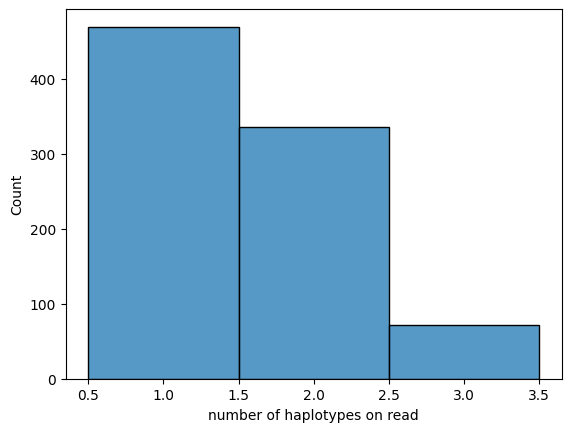

In [4]:
gx = read_phasing.groupby('read_name')['haplotype'].nunique()
sns.histplot(gx, discrete=True)
plt.xlabel('number of haplotypes on read')
plt.show()

Text(0, 0.5, 'number of reads (unique)')

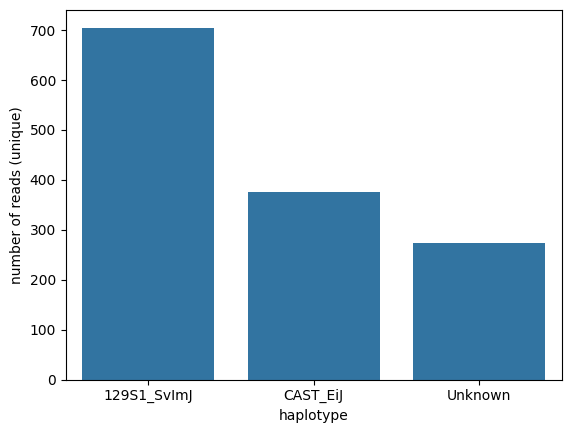

In [5]:
gx = read_phasing.groupby('haplotype')['read_name'].nunique().reset_index(drop=False)

sns.barplot(data=gx, 
            x='haplotype',
            y='read_name',)

plt.xlabel('haplotype')
plt.ylabel('number of reads (unique)')

Text(0, 0.5, 'number of chromosome blocks')

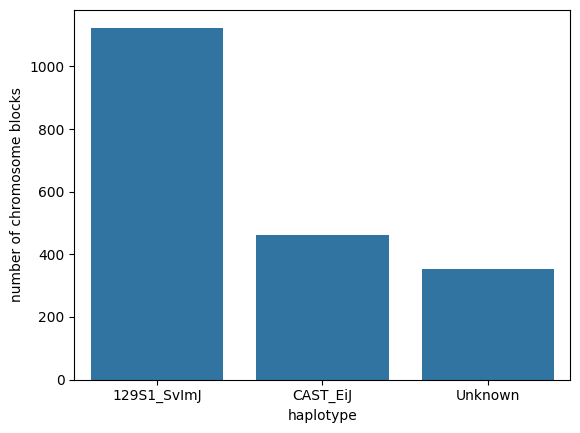

In [6]:
gx = read_phasing['haplotype'].value_counts().reset_index(drop=False)

sns.barplot(data=gx, 
            x='haplotype',
            y='count',)

plt.xlabel('haplotype')
plt.ylabel('number of chromosome blocks')